### Simple ABM Implementation of Shooting Problem in "Causality and Counterfactuals in the Situation Calculus" by Hopkins and Pearl ###

#### Paul Cohen, Oct 3, 2022 ####

Following Jeremy's good suggestion that Hopkins and Pearl probabilistic situation calculus might be a good language in which to express models, and that the Mecha paclage might easily be used to implement such models, I started to write a Mecha model for the Shooting Problem.  Mecha is too heavy-weight for the problem so I wrote a very simple ABM in pandas/numpy.  

In [162]:
import os
os.chdir("/Users/prcohen/Pitt/Code/Mechanisms")

import numpy as np
from numpy.random import default_rng
rng = default_rng() # stuff for random sampling

import pandas as pd
import matplotlib.pyplot as plt

# Number of sampled conditions
n = 1000

def prob(col):
    return np.sum(col)/n

def plot_results (results):
    plt.plot(results['pSignal'], label='pSignal', color='green')
    plt.plot(results['pShoots1'], label='pShoots1', color='lightblue')
    plt.plot(results['pShoots2'], label='pShoots2', color='steelblue')
    plt.plot(results['pDead'], label='pDead', color='red')
    plt.legend()
    plt.show()
    

I like to run the same experiment in multiple conditions in parallel by setting it up as an ABM.  We will have `n` conditions that sample probabilities of the captain signaling, the riflemen shooting and the prisoner dying. We initialize the simulation by specifying four parameters:

1) The probability that the captain wants to signal

2) The probability that rifleman 1 wants to shoot

3) The probability that rifleman 2 wants to shoot

4) The probability that the prisoner is already dead

In [163]:
def init_sim (p_wantsToSignal, p_wantsToShoot1, p_wantsToShoot2, p_alreadyDead): 
    ''' Make dataframes for simulation state and results.  Initialize the probabilities 
    of signaling and shooting at each time step'''
    
    df = pd.DataFrame(
        np.zeros((n,7)).astype(bool),
        columns=['wantsToSignal','Signal','wantsToShoot1','Shoots1','wantsToShoot2','Shoots2','dead'])
    
    results = pd.DataFrame(columns=['pSignal','pShoots1','pShoots2','pDead'])
    
    df.wantsToSignal = rng.random(n) < p_wantsToSignal
    df.wantsToShoot1 = rng.random(n) < p_wantsToShoot1
    df.wantsToShoot2 = rng.random(n) < p_wantsToShoot2
    df.dead = rng.random(n) < p_alreadyDead
    
    return df,results

df,results = init_sim(.7,.3,.8,.05)
df

,wantsToSignal,Signal,wantsToShoot1,Shoots1,wantsToShoot2,Shoots2,dead
0,True,False,True,False,True,False,False
1,True,False,False,False,True,False,False
2,True,False,False,False,True,False,False
3,True,False,True,False,True,False,False
4,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...
995,True,False,False,False,True,False,False
996,True,False,False,False,False,False,False
997,True,False,True,False,True,False,False
998,True,False,False,False,True,False,False


The rows are not unique.  Some are more common than others.  

Now we define four rules.

In [164]:
def Signals (p_hasty):
    # The captain will signal if he hasn't signaled, if he wants to signal, and
    # with a probability that is proportional to his haste
    df.Signal = (df.Signal) | ( (df.wantsToSignal) & (rng.random(n) < p_hasty) )
    
def Shoots1 (p_sloppy):
    # Rifleman 1 shoots is True if he has already shot, if he hears a signal and wants
    # to shoot, or if he's sloppy
    df.Shoots1 = df.Shoots1 | (df.Signal & df.wantsToShoot1) | (rng.random(n) < p_sloppy)
    
def Shoots2 (p_sloppy):
    # Rifleman 2 shoots is True if he has already shot, if he hears a signal and wants
    # to shoot, or if he's sloppy
    df.Shoots2 = df.Shoots2 | (df.Signal & df.wantsToShoot2) | (rng.random(n) < p_sloppy)
    
def Dies ():
    # The prisoner dies if either rifleman shoots
    df.dead = (df.dead) | (df.Shoots1) | (df.Shoots2)

Now we intialize the simulation and run all the rules at each of 20 time steps.

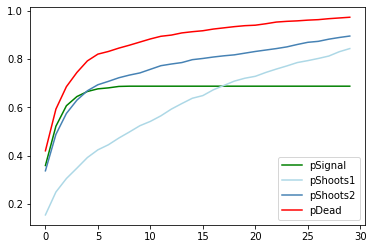

In [165]:
df,results = init_sim(.7,.3,.8,.05)

for i in range(30):
    Signals(.5)
    Shoots1(.05)
    Shoots2(.05)
    Dies()
    results.loc[len(results)] = [prob(df.Signal),prob(df.Shoots1),prob(df.Shoots2),prob(df.dead)]
    
plot_results(results)

In [180]:
results

,pSignal,pShoots1,pShoots2,pDead
0,0.368,0.153,0.334,0.437
1,0.557,0.242,0.501,0.608
2,0.641,0.303,0.582,0.693
3,0.698,0.346,0.645,0.752
4,0.717,0.384,0.683,0.793
5,0.722,0.420,0.705,0.812
6,0.727,0.441,0.718,0.830
7,0.729,0.470,0.737,0.849
8,0.730,0.497,0.752,0.864
9,0.731,0.519,0.762,0.874


Now we can calculate transition probabilities between states.  A state is indexed by time (the step of the simulation) and is a vector of four binary variables -- Signal,Shoots1,Shoots2,dead.  For ease of human comprehension (though it slows things down), states are represented by strings; for example, '0101' represents no signal, rifleman 1 shoots, rifleman 2 doesn't shoot, and the prisoner is dead. 

Each state has a probability which is the number of rows in our numpy array at a given time that match that state. We can then ask for the conditional probability of any given next state given a current state. 

In [186]:
ht = {}

# Keep this, it's for state arrays rather than state strings
# def transition0 (x0,x1,time):
#     ht[time]={}
#     u0,c0 = np.unique(x0,axis=0,return_counts=True)
#     print(u0,c0)
#     for pattern0,count0 in zip(u0,c0): 
#         u1,c1 = np.unique(x1[np.all(x0==pattern0,axis=1)],axis=0,return_counts=True)
#         ht[time].update({str(pattern0):{str(pattern1):np.round(count1/count0,3) for pattern1,count1 in zip(u1,c1)}})

def transition (x0,x1,time):
    ss0 = x0.apply(state_string,axis=1)
    ss1 = x1.apply(state_string,axis=1)
    ht[time]={}
    u0,c0 = np.unique(ss0,return_counts=True)
    for pattern0,count0 in zip(u0,c0): 
        u1,c1 = np.unique(ss1[ss0==pattern0],return_counts=True)
        ht[time].update({str(pattern0):{str(pattern1):np.round(count1/count0,3) for pattern1,count1 in zip(u1,c1)}})    
        
def q_prob (time,state0,state1):
    s = ht.get(time)
    if s:
        s0 = s.get(state0)
        if s0:
            s1 = s0.get(state1)
            if s1:
                print(f'At time {time}, P({state1}|{state0})={s1}')
            else:
                print(f'At time {time}, {state1} is not a successor to {state0}')
        else:
            print(f'At time {time}, {state0} does not exist')                 
    else:
        print(f'time {time} does not exist')
    
        
def state_string (x):
    return "".join([str(i) for i in x])
    
        
df,results = init_sim(.7,.3,.8,.05)
x0 = df[['Signal','Shoots1','Shoots2','dead']].astype(int)

for time in range(10):
    Signals(.5)
    Shoots1(.05)
    Shoots2(.05)
    Dies()
    
    x1 = df[['Signal','Shoots1','Shoots2','dead']].astype(int)
    transition(x0,x1,time)
    # query the probability of a state of x1 given a state of x0
    q_prob(time,'1000','1011')
    x0 = x1
    


At time 0, 1000 does not exist
At time 1, P(1011|1000)=0.026
At time 2, P(1011|1000)=0.057
At time 3, P(1011|1000)=0.038
At time 4, P(1011|1000)=0.022
At time 5, P(1011|1000)=0.048
At time 6, 1011 is not a successor to 1000
At time 7, P(1011|1000)=0.135
At time 8, P(1011|1000)=0.032
At time 9, P(1011|1000)=0.071
